##  WEB SCRAPING --> CLEANING AND PERFORMING SENTIMENT ANALYSIS

The goal in this example is to clean and format in a convenient way the data scraped from an online website for restaurants reviews. Then we want to perform sentiment analysis to detect the preferences of our target, that is, what are the aspects they appreciate more and which ones are the lowest rated.

### IMPORTING LIBRARIES

In [1]:
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

### DEFINING SOME CUSTOM FUNCTIONS TO SCRAPE THE INFO

After analyse the website content we want to scrape, we have determine the best way to do so is to define several custom functions to collect the data and also to clean it at the same time. The functions below make all these tasks.

In [19]:
#Custom function to clean spaces and tabular characters:

def formatting(data):
    data=[i.replace('\n', '').replace('\t', '') for i in data]
    return data

In [20]:
#Custom Function to scrape, compile and format html scraped content. We just need to pass the 'soup' content and the 
#function returns a dataframe with all formatted information and reviews from restaurants.


def scraping_html(soup):
    
    names = [name.text for name in soup.findAll('div', {'class': 'listing-item-title'})]
    locations = [location.text for location in soup.findAll('div', {'class': 'listing-item-location'})]
    address=[addres.text for addres in soup.findAll('div', {'class': 'listing-item-address'})]
    descriptions=[description.text for description in soup.findAll('div', {'class': 'item-description-text'})]
    slogans=[slogan.text for slogan in soup.findAll('div', {'class': 'item-description-text description-slogan'})]
    decos=[deco.text for deco in soup.findAll('div', {'class': 'item-rating-info-block'})]
    likes=[like.text for like in soup.findAll('div', {'class': 'item-score-info-block les_gusta'})]
    titles=[title.get('title') for title in soup.findAll('div', {'class': 'mini-icon-block'})]
    
    all_reviews=[]
    #all_ratings=[]
    driver.maximize_window()
    for idx, name in enumerate(names):
        links = driver.find_elements_by_class_name('listing-item-rating-reviews')
        link=links[idx]
        if link.text=='opinar ahora':
            all_reviews.append('')
            #all_ratings.append(0.0)
        else:
            if link.text=='1 opinión':
                One_opinion=True
            else:
                One_opinion=False
                
            button=link.click() 
            time.sleep(5)
            driver.set_window_size(600, 450) #Resize window
            page_source = driver.page_source
            soup2 =  BeautifulSoup(page_source, 'lxml')
            reviews=[review.text for review in soup2.findAll('p', {'class': 'excerpt'})]
            all_reviews.append(reviews)
            
            '''if One_opinion==False:
                item_rate = driver.find_elements_by_class_name("review-item-description-col")
                for k in item_rate:
                    rate = k.find_element_by_xpath('//div[2]/div[2]/div[1]/div[2]/div/div')
                    all_ratings.append(rate.text)
            else:
                rate = driver.find_element_by_xpath('//div[2]/div[1]/div[19]/div/div[1]/div/div/div[1]/div[2]/div/div/span')
                all_ratings.append(rate.text)
            '''
            driver.execute_script("window.history.go(-1)")
    
    #We will keep only the first split part from the entire text description (where the most important info is)
    
    for i in range(len(slogans)):
        if slogans[i] in descriptions:
            descriptions.remove(str(slogans[i]))
        
    #Cleaning the columns and keeping only the part we are interested in:
    descriptions = [i.split('.')[0] for i in descriptions] 
    locations = [i.split('Restaurante en')[1] for i in locations] 
    address = [i.split('|')[0] for i in address] 
    likes = [i.split('les gusta')[0] for i in likes] 
    likes = [i.split('%')[0] for i in likes] 
    
    #Creating the dataframe
    features=[names,locations,address,descriptions,likes]
    columns=[formatting(feature) for feature in features]
    keys=['names','locations','address','descriptions','likes %']
    values=[columns[0],columns[1],columns[2],columns[3],columns[4]]
    result = dict(zip(keys,values))
    df=pd.DataFrame(result)
    
    #Grouping in columns the rates for each one of the restaurant services: food, service, price and accomodation.

    decos=formatting(decos)
    decor=[decos[i] for i in range(0,len(decos),4)]
    service=[decos[i] for i in range(1,len(decos),4)]
    food=[decos[i] for i in range(2,len(decos),4)]
    price=[decos[i] for i in range(3,len(decos),4)]

    menus=[titles[i] for i in range(2,len(titles),5)]
    cartas=[titles[i] for i in range(3,len(titles),5)]
    degustation=[titles[i] for i in range(4,len(titles),5)]

    #We keep only the numeric content, although we don´t convert it to integer yet:
    decor=[i.split('deco')[1] for i in decor]
    service=[i.split('servicio')[1] for i in service]
    food=[i.split('comida')[1] for i in food]
    price=[i.split('precio')[1] for i in price]
    
    #Mean prices.

    def ratings(rate):
        for idx,i in enumerate(rate):
            if i is not None:
                rate[idx]=i.split(':')[1] 
        return rate

    menus=ratings(menus)
    cartas=ratings(cartas)
    degustation=ratings(degustation)

    #Creating another second dataframe
    keys=['decor','service','food','price','menus','cartas','degustation']
    values=[decor,service,food,price,menus,cartas,degustation]
    result2 = dict(zip(keys,values))
   
    df2=pd.DataFrame(result2)
    df=df.join(df2)
    return df, all_reviews

### SCRAPING THE INFORMATION

In [21]:
#Searching the total number of pages to scrape.

options = webdriver.ChromeOptions()
driver = webdriver.Chrome(executable_path='C:/Users/Arantxa Fernandez/ChromeDriver/chromedriver.exe', options=options)
driver.get('http://www.buscorestaurantes.com/especial/Restaurantes-Romanticos/Bizkaia')

page_source = driver.page_source
soup =  BeautifulSoup(page_source, 'lxml')

num_pages=driver.find_element_by_xpath('/html/body/div[1]/div[1]/div[4]/section/div[4]/div[4]/nav/ul/li[2]/span').text
num_pages=num_pages.split('de')[1].strip()
num_pages=int(num_pages)
romantic_rest, reviews=scraping_html(soup)

#For loop over the entire range of pages and scraping the information. 

for i in range(num_pages-1):
    
    button_one = driver.find_element_by_xpath('/html/body/div[1]/div[1]/div[4]/section/div[4]/div[4]/nav/ul/li[3]/a/span[1]').click()
    time.sleep(10)
   
    page_source = driver.page_source
    soup =  BeautifulSoup(page_source, 'lxml')
    restaurants, reviews2=scraping_html(soup)
    romantic_rest=pd.concat([romantic_rest,restaurants])
    reviews = [*reviews, *reviews2]

romantic_rest=romantic_rest.reset_index().drop(['index'], axis=1)

At this point, we already have all the information with a convenient format in a Pandas dataframe called 'romantic_rest' and also all the reviews for each one of these restaurants in a list called 'reviews'. 

### SAVING THE DATAFRAME AND REVIEWS

Perhaps we don´t want to execute the scrape function each time, if we have noticed that the online data has not changed since the last time. We can save the dataframe for eventually analysis and only re-run the scrape function if we want to refresh it.

In [23]:
#Saving the dataframe and the reviews dataframe.

romantic_rest.to_csv('romantic_rest_scraped.csv')

#Saving the list of reviews

with open('reviews.txt', 'w') as output_file:
    for review in reviews:
        output_file.write(str(review) + '\n')
output_file.close()


### LOADING THE DATAFRAME AND REVIEWS

In [24]:
romantic_rest=pd.read_csv('romantic_rest_scraped.csv')
reviews=[]
with open('reviews.txt') as f:
        reviews=f.readlines()

### FORMATTING THE DATAFRAME

In [25]:
#Let´s fill '--' and 'none' values in columns with 0.0

romantic_rest['likes %']=romantic_rest['likes %'].replace('--','0').astype(int)
float_columns=['decor','service', 'food', 'price']
for col in float_columns:
    romantic_rest[col]=romantic_rest[col].replace('--','0.0').astype(float)


In [26]:
#We will consider ranges of prices in menus as categorical features with ordinal behaviour; so we will perform a 'mapping'
#with the following labels: None=0; Less than 15€=1; 15-25=2; 26-35=3, 36-50=4

mapping={'+100 €':5,'76-100 €':5,'51-75 €':4,'36-50 €':4,'26-35 €':3,'15-25 €':2,'Menos de 15 €':1, '0':0}

columns=['menus','cartas','degustation']
for col in columns:
    romantic_rest[col]=romantic_rest[col].fillna('0')
    romantic_rest[col]=romantic_rest[col].apply(lambda x: x.strip())
    romantic_rest[col]=romantic_rest[col].map(mapping)

In [27]:
romantic_rest.head()

,Unnamed: 0,names,locations,address,descriptions,likes %,decor,service,food,price,menus,cartas,degustation
0,0,Bilbo Handia,Bilbao,"Indalecio Prieto, 1",El Restaurante Bilbo Handia - Hotel Sercotel G...,40,6.7,6.8,6.7,6.6,2,3,4
1,1,Igeretxe Restaurante,Getxo,"Muelle Ereaga, 3","Hotel Restaurante Igeretxe, ubicado en Getxo, ...",72,7.6,7.0,7.6,7.6,2,4,0
2,2,Asador La Fábrica de Juan,Abanto y Ciérvana-Abanto Zierbena,"Playa de la Arena, 22",LA FABRICA DE JUAN se encuentra junto a la pla...,71,8.1,8.2,8.2,8.2,1,3,4
3,3,Asador Garufa Parrilla Argentina,Bilbao,"Villarias, 2","Asador Garufa Parrilla Argentina, con 100m2 y ...",7,3.8,3.8,3.8,3.8,1,3,3
4,4,Baita Gaminiz,Bilbao,"Alameda Mazarredo, 20",El Restaurante Baita Gaminiz está situado en e...,32,5.4,5.4,5.4,5.4,0,4,4


In [16]:
reviews[0:2]

[]

We could perform an EDA over the dataframe to see best rated restaurants by locations, type of menus, and so on. But as we have already performed this process in other scraped examples, we will focus in Sentiment Analysis in this one. After calculating a 'Sentiment' value for the reviews, we will estimate a mean value for the customers opinion about each restaurant and we will add this information as another column in our dataframe.

### FORMATTING REVIEWS

In [28]:
reviews=[line.split(", '\\n\\t") for line in reviews]

In [31]:
#Custom function to preprocess reviews:
import re
def preprocessing(text):
    text=text.lower()                                     #Convert text to lower case
    text=re.sub(r'http\S+','', text)                      #Removing links:https
    text=text.replace('\\n',' ').replace('\\t',' ')       #Removing \n characters
    text=re.sub(r'[^\w\s]', '',text)                      #Removing punctuation
    text=''.join(c for c in text if not c.isnumeric())    #Removing numbers
    text=text.strip()                                     #Removing blanks
    return text

In [32]:
reviews_format=[]
for rev in reviews:
    reviews_=[preprocessing(review) for review in rev]
    reviews_format.append(reviews_)

In [33]:
#Let´s see one formatted item in reviews
reviews_format[2]

['no tenia nada para niños en esto defraudado pues no me dieron ninguna alternativa resto de comida bien',
 'la atención del personal ha sido muy buena y la cena muy rica la verdad lo recomiendo creo que repetiremos',
 'aconsejo ir es fantástico pero la parrilla que está cerca fatal a las  no tenían casi nada para comer nos fuimos pésimo',
 'personal muy atento y el servicio impecable con mucha paciencia y buenas maneras  la comida muy buena lo recomiendo',
 'el menú de diario muy correcto por  euros más iva ofrecen  primeros entrantes todos interesantes así como segundos abundantes y de calidad para ser un menú diario buena opción si uno se acerca a esta zona y no quiere recurrir al típico plato combinado de los bares de la zona',
 'en cuestión calidad precio el menú diario tiene amplia oferta para ser un menú esta bastante elaborado y es todo un acierto incluir un criancita en el menú por dos euros mas nos ha gustado',
 'pues como menú del día lo recomiendo no es un sitio para salir 

### SENTIMENT ANALYSIS

SENTIMENT ANALYSIS METHOD 1: NLTK LIBRARY AND TEXTBLOB

In [98]:
#Definition of some custom functions to perform preprocessing of reviews texts.

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords

#Selection of Dictionary for Stopwords and adding some additional words:

stopwords = nltk.corpus.stopwords.words('spanish')
newStopWords = ['si','luego','delante']
stopwords.extend(newStopWords)  

def list_to_str(feature):     #Function to return a unique joined string from a list of words.
    joined_text=feature
    joined_text=' '.join(feature)
    return joined_text

def polarity(feature):
    polarity=TextBlob(feature).sentiment.polarity 
    return polarity
def subjectivity(feature):
    subjectivity=TextBlob(feature).sentiment.subjectivity 
    return subjectivity
def Stemming(feature):
    stemmer = nltk.stem.PorterStemmer()
    stemmed_text=[''.join(stemmer.stem(i)) for i in feature]
    return stemmed_text
def Lemmatization(feature):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemma_text=[''.join(lemmatizer.lemmatize(i)) for i in feature]
    return lemma_text

By providing an input sentence, the TextBlob’s sentiment property returns a named tuple with polarity and subjectivity scores. The polarity score ranges from -1.0 to 1.0 (-1 is a negative sentiment, 0 is neutral and 1.0 is a positive sentiment) and the subjectivity ranges from 0.0 to 1.0 where 0.0 is an objective statement and 1 is a subjective statement.

In [99]:
def sentiment_analisis(reviews):
    sentiment=[]
    if len(reviews)==0:
        sentiment.append(0.0,0.0,0.0,0.0,0.0,0.0)
    else:
        for review in reviews:
            
            #Preprocessing the text
            review_stopped=[i for i in review.split(' ') if not i in stopwords]
            review_stopped=list_to_str(review_stopped)
            
            #Lemmatization and Stemming
            review_lemma=Lemmatization(review_stopped.split())
            review_stemm=Stemming(review_stopped.split())
            
            #Polarity and Subjectivity without Lemmatization either stemming
            pol_original=polarity(review_stopped)
            sub_original=subjectivity(review_stopped)
            
            #Polarity and Subjectivity with Lemmatization 
            pol_lemma=polarity(list_to_str(review_lemma))
            sub_lemma=subjectivity(list_to_str(review_lemma))
            
            #Polarity and Subjectivity with stemming
            pol_stemm=polarity(list_to_str(review_stemm))
            sub_stemm=subjectivity(list_to_str(review_stemm))
            
            sentiment.append([pol_original, sub_original, pol_lemma, sub_lemma, pol_stemm, sub_stemm])
        
    return sentiment


In [100]:
#Performing sentiment for all reviews:

import numpy as np

sentiments=[]
for rev in reviews_format:
    sentiments.append(sentiment_analisis(rev))  

In [101]:
#Sentiments in flat format to create a Sentiment Dataframe

sentiments_f=[sent for sentiment in sentiments for sent in sentiment]
columns=['pol_original', 'sub_original', 'pol_lemma', 'sub_lemma', 'pol_stemm', 'sub_stemm']
sentiment_df=pd.DataFrame(sentiments_f, columns=columns)
sentiment_df.head(10)

,pol_original,sub_original,pol_lemma,sub_lemma,pol_stemm,sub_stemm
0,0.00,0.0,0.00,0.0,0.000,0.000
1,0.05,0.5,0.05,0.5,0.500,1.000
2,0.00,0.0,0.00,0.0,0.000,0.000
3,0.00,0.0,0.00,0.0,0.000,0.000
4,0.00,0.3,0.00,0.3,0.000,0.000
5,0.00,0.0,0.00,0.0,0.000,0.000
6,0.00,0.3,0.00,0.3,0.000,0.000
7,0.00,0.0,0.00,0.0,0.325,0.525
8,0.00,0.0,0.00,0.0,0.000,0.000
9,0.00,0.3,0.00,0.3,0.000,0.000


Now we will perform the sentiment analysis with another library that rather than determine if a sentence is objective or subjective, it tells us if a sentence is positive, negative or neutral.

SENTIMENT ANALYSIS METHOD 2: VADER

Vader is a lexicon model used for sentiment analysis in NLTK. It can handle capital letters, punctuations, emoticons, abbreviations, etc. This is great, because we don´t need to perform all this operations as we have done before. The output of VADER is a dictionary with 4 fields: Neg, Neu, Pos (indicating negative, neutral and positive sentiment) and Compound is a numerical value that summarizes the overall sentiment of a sentence, by this way:
- If the value is higher or equal to 0.05 the sentiment is positive.
- If the value is lower or equal to -0.05 the sentiment is negative.
- If the value is between -0.05 and 0.05 the sentiment is neutral.


In [102]:
#Importing libraries and downloading the lexicon

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to C:\Users\Arantxa
[nltk_data]     Fernandez\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [104]:
#Finding the sentiment of each sentence

sent_analyzer = SentimentIntensityAnalyzer()

sentiment_=[]
sentiment='neutral'
rates=[]


reviews_f=[rev for review in reviews_format for rev in review]
for review in reviews_f:
    
    review_stopped=[i for i in review.split(' ') if not i in stopwords]
    review_stopped=list_to_str(review_stopped)
    reviews_lem=Lemmatization(review_stopped.split())
    reviews_lem=list_to_str(reviews_lem)
    output_dict=sent_analyzer.polarity_scores(reviews_lem)
    
    if (output_dict['compound']>=0.05):
        sentiment='positive'
    elif (output_dict['compound']<=-0.05):
        sentiment='negative'
    else:
        sentiment='neutral'
    sentiment_.append(sentiment)
    rates.append(output_dict['compound'])


In [109]:
sentiment_df['VADER']=sentiment_
sentiment_df['VADER_rates']=rates
sentiment_df.iloc[0:15,:]

,pol_original,sub_original,pol_lemma,sub_lemma,pol_stemm,sub_stemm,VADER,VADER_rates,Rest_name
0,0.00,0.000000,0.00,0.000000,0.000,0.000,neutral,0.0000,Bilbo Handia
1,0.05,0.500000,0.05,0.500000,0.500,1.000,neutral,0.0000,Bilbo Handia
2,0.00,0.000000,0.00,0.000000,0.000,0.000,neutral,0.0000,Igeretxe Restaurante
3,0.00,0.000000,0.00,0.000000,0.000,0.000,neutral,0.0000,Asador La Fábrica de Juan
4,0.00,0.300000,0.00,0.300000,0.000,0.000,neutral,0.0000,Asador La Fábrica de Juan
5,0.00,0.000000,0.00,0.000000,0.000,0.000,negative,-0.5423,Asador La Fábrica de Juan
6,0.00,0.300000,0.00,0.300000,0.000,0.000,neutral,0.0000,Asador La Fábrica de Juan
7,0.00,0.000000,0.00,0.000000,0.325,0.525,neutral,0.0000,Asador La Fábrica de Juan
8,0.00,0.000000,0.00,0.000000,0.000,0.000,neutral,0.0000,Asador La Fábrica de Juan
9,0.00,0.300000,0.00,0.300000,0.000,0.000,neutral,0.0000,Asador La Fábrica de Juan


As we can see both methods performs with different precission over the examples, but in general shows similar outputs. VADER seems to capture more information for some rows than textblob. We will use VADER result to add this information to our previous dataframe.

Anyway, there is a gap between the value provided with these methods and the real opinion of users. If we compare the result obtained for some of the reviews and the real text, we observe discrepancies, for example let´s take a positive review of a restaurant:

In [118]:
reviews_f[6]
review_stopped=[i for i in reviews_f[6].split(' ') if not i in stopwords]
review_stopped=list_to_str(review_stopped)
reviews_lem=Lemmatization(review_stopped.split())
reviews_lem=list_to_str(reviews_lem)
output_dict=sent_analyzer.polarity_scores(reviews_lem)
output_dict

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [119]:
reviews_lem

'personal atento servicio impecable mucha paciencia buenas maneras comida buena recomiendo'

Result of VADER shows a neutral opinion but the real opinion is quite positive; so we need a better performance of the methods applied. These could be optimized with a trained model using Logistic Regression or Naive Bayes with TF-IDF techniques.

In [106]:
#Let´s see the number of reviews for each restaurant

count=[]
for review in reviews_format:
    count.append(len(review))
    
#Calculating a sentiment mean value for each restaurant using the previous 'VADER_rates' column:

import numpy as np
array_size=np.array(sentiment_df['VADER_rates'])
names=[]
for idx,name in enumerate(romantic_rest['names']):
    for num in range(count[idx]):
        names.append(name)

In [107]:
#Adding this extra column with restaurant names to 'sentiment_df' dataframe, calculating rates mean and saving this in 
#a dictionary.

sentiment_df['Rest_name']=names
VADER_mean=sentiment_df.groupby('Rest_name')['VADER_rates'].mean()
dicty=dict(VADER_mean)

#Adding this information to the original dataframe:

romantic_rest['VADER_rate']=romantic_rest['names'].map(dicty)

In [115]:
romantic_rest.head()

,Unnamed: 0,names,locations,address,descriptions,likes %,decor,service,food,price,menus,cartas,degustation,VADER_rate
0,0,Bilbo Handia,Bilbao,"Indalecio Prieto, 1",El Restaurante Bilbo Handia - Hotel Sercotel G...,40,6.7,6.8,6.7,6.6,2,3,4,0.000000
1,1,Igeretxe Restaurante,Getxo,"Muelle Ereaga, 3","Hotel Restaurante Igeretxe, ubicado en Getxo, ...",72,7.6,7.0,7.6,7.6,2,4,0,0.000000
2,2,Asador La Fábrica de Juan,Abanto y Ciérvana-Abanto Zierbena,"Playa de la Arena, 22",LA FABRICA DE JUAN se encuentra junto a la pla...,71,8.1,8.2,8.2,8.2,1,3,4,-0.018675
3,3,Asador Garufa Parrilla Argentina,Bilbao,"Villarias, 2","Asador Garufa Parrilla Argentina, con 100m2 y ...",7,3.8,3.8,3.8,3.8,1,3,3,0.000000
4,4,Baita Gaminiz,Bilbao,"Alameda Mazarredo, 20",El Restaurante Baita Gaminiz está situado en e...,32,5.4,5.4,5.4,5.4,0,4,4,0.000000


### WORDCLOUD

Another interesting thing to perform with this type of data is a Word cloud. A wordcloud is a plot with the most commom words used by users in reviews. The bigger the word in plot the higher the word frequency of appearance.

In [120]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

In [121]:
#Lemmatizing reviews

lemmatized=[]
for review in reviews_f:
    
    review_stopped=[i for i in review.split() if not i in stopwords]
    review_stopped=list_to_str(review_stopped)
    lemmatized.append(Lemmatization(review_stopped.split()))
lemmatized_f=[lem for lemma in lemmatized for lem in lemma]
words=' '.join(word for word in lemmatized_f)

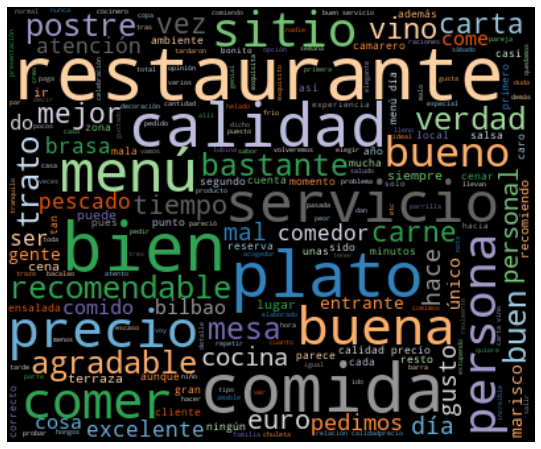

In [122]:
#Performing WordCloud
wc = cloud = WordCloud(width=400,
                      height=330,
                      max_words=200,
                      colormap='tab20c',
                      stopwords=stopwords,
                      collocations=True).generate_from_text(words)

plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

We see that in general, for most of the restaurants, opinions are good, as the plot shows positive words with a bigger letters. We could also customized the image shape using the 'mask' parameter:

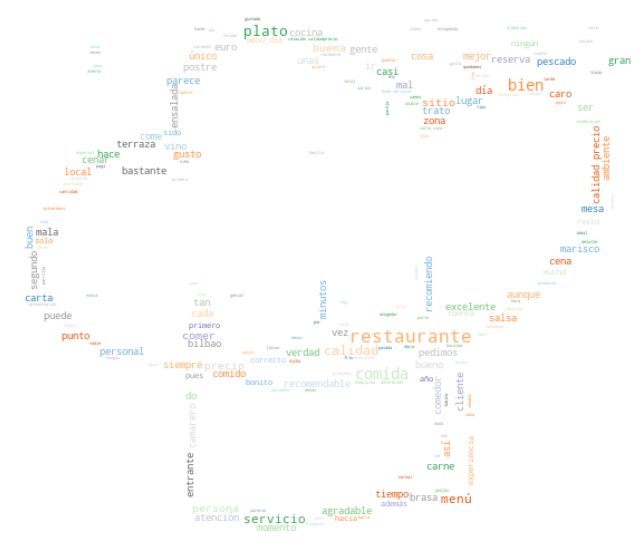

In [123]:
mask = np.array(Image.open('/Users/Arantxa Fernandez/PYTHON JUPITERS PROJECTS/chef.jpg'))

wc = cloud = WordCloud(width=400,
                      height=330,
                      max_words=200,
                      mask=mask,
                      colormap='tab20c',
                      stopwords=stopwords,
                      background_color='white',
                      collocations=True).generate_from_text(words)

plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');